# Transfer Learning with Tensorflow part 2 : Fine tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Thu Jan 26 08:08:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
!wget https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py

--2023-01-26 08:08:29--  https://raw.githubusercontent.com/maulairfani/DataScience-Learning-Notebooks/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-26 08:08:30 (51.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-26 08:08:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 172.217.193.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   234MB/s    in 0.7s    

2023-01-26 08:08:37 (234 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


2023-01-26 08:08:40.929712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 08:08:40.930635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 08:08:41.077911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 08:08:41.078840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 08:08:41.079661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

2023-01-26 08:08:45.122597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(
[[[[2.39897964e+02 2.36255112e+02 2.23826538e+02]
   [2.44790817e+02 2.37816330e+02 2.28959183e+02]
   [2.44025513e+02 2.32811218e+02 2.31668365e+02]
   ...
   [2.26581680e+02 2.10581680e+02 2.22010208e+02]
   [2.24994888e+02 2.08994888e+02 2.18994888e+02]
   [2.20137650e+02 2.05137650e+02 2.12137650e+02]]

  [[2.40209183e+02 2.36280624e+02 2.36852051e+02]
   [2.39551025e+02 2.34352036e+02 2.31336731e+02]
   [2.43755096e+02 2.34285706e+02 2.35770416e+02]
   ...
   [2.23989990e+02 2.07989990e+02 2.19418518e+02]
   [2.18561295e+02 2.02561295e+02 2.12561295e+02]
   [2.26168030e+02 2.11168030e+02 2.18168030e+02]]

  [[2.45846939e+02 2.40489792e+02 2.50275513e+02]
   [2.40459183e+02 2.34887741e+02 2.45943878e+02]
   [2.35525513e+02 2.29051025e+02 2.44357147e+02]
   ...
   [2.23964432e+02 2.07964432e+02 2.19729706e+02]
   [2.18071472e+02 2.02071472e+02 2.13015335e+02]
   [2.26372330e+02 2.10372330e+02 2.20372330e+02]]

  ...

  [[2.27387726e+02 2.21387726e+02 2.23387726e+02]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

it gives us more flexibel with our models

In [11]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the basee model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the modt important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine th einputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(len(test_data_10_percent)*.25),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)


2023-01-26 08:08:48.208749: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:08:48.208785: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 08:08:48.211222: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-26 08:08:48.676239: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:08:48.676443: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230126-080848
Epoch 1/5


2023-01-26 08:08:56.036038: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/24 [>.............................] - ETA: 5:28 - loss: 2.3397 - accuracy: 0.0625

2023-01-26 08:09:03.398451: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:09:03.398499: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 20s - loss: 2.3616 - accuracy: 0.0469 

2023-01-26 08:09:04.191902: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 08:09:04.192886: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 08:09:04.356016: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 547 callback api events and 544 activity events. 
2023-01-26 08:09:04.375810: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/24 [==>...........................] - ETA: 14s - loss: 2.3356 - accuracy: 0.0521

2023-01-26 08:09:04.408627: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_feature_extraction/20230126-080848/train/plugins/profile/2023_01_26_08_09_04

2023-01-26 08:09:04.422500: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_feature_extraction/20230126-080848/train/plugins/profile/2023_01_26_08_09_04/a625c8d8be8a.trace.json.gz
2023-01-26 08:09:04.468449: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_feature_extraction/20230126-080848/train/plugins/profile/2023_01_26_08_09_04

2023-01-26 08:09:04.476011: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to transfer_learning/10_percent_feature_extraction/20230126-080848/train/plugins/profile/2023_01_26_08_09_04/a625c8d8be8a.memory_profile.json.gz
2023-01-26 08:09:04.47

24/24 [==============================] - 21s 307ms/step - loss: 1.8982 - accuracy: 0.3960 - val_loss: 1.3232 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 4s 161ms/step - loss: 1.1355 - accuracy: 0.7347 - val_loss: 0.9131 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 4s 158ms/step - loss: 0.8416 - accuracy: 0.8093 - val_loss: 0.7531 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 5s 181ms/step - loss: 0.6877 - accuracy: 0.8373 - val_loss: 0.6400 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5859 - accuracy: 0.8787 - val_loss: 0.6038 - val_accuracy: 0.8438


In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


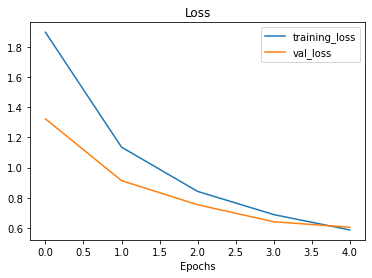

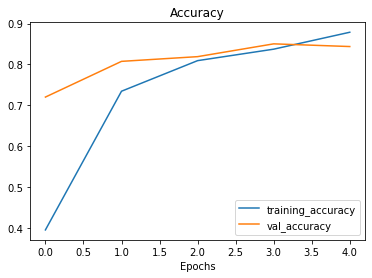

In [15]:
# Check out our model's training curves
plot_loss_curves(history_model_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePooling2D layer, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3)

In [16]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooled 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of 2 different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

we'll go with 1% data instead of 10%

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction with 10% of training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` -  use fine-tuning transfer learning on 100% of the training data with data augmentation

### Getting and preprocessing data for model_1

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-01-26 08:09:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 172.217.203.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   233MB/s    in 0.5s    

2023-01-26 08:09:36 (233 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test"

# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [20]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

* `tf.keras.layers.experimental.preprocessing()`

the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happends on the GPU
* Image data augmentation only happens during training, so we can still export our whole model an duse it elsewhere (bisa sekalian di save)

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) 
], name="data_augmentation")

 ### Visualize our data augmentation layer (and see what happens to our data)

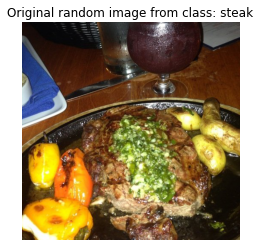

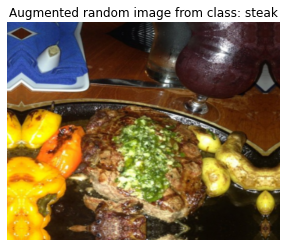

In [22]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

2023-01-26 08:09:41.328331: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:09:41.328371: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 08:09:41.947039: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:09:41.947218: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230126-080941
Epoch 1/5
1/3 [=========>....................] - ETA: 11s - loss: 2.4706 - accuracy: 0.1250

2023-01-26 08:09:48.138481: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:09:48.138557: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/3 [===================>..........] - ETA: 0s - loss: 2.4752 - accuracy: 0.0938 

2023-01-26 08:09:49.319456: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 08:09:49.322369: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 08:09:49.488943: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2621 callback api events and 2284 activity events. 
2023-01-26 08:09:49.533987: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:09:49.593384: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/1_percent_data_aug/20230126-080941/train/plugins/profile/2023_01_26_08_09_49

2023-01-26 08:09:49.628487: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to transfer_learning/1_percent_data_aug/20230126-080941/train/plugins/profile/2023_01_26_08_09_49/a625c8d8be8a.trace.json.gz
2023-01-26 08:09:49.6832

3/3 [==============================] - 12s 3s/step - loss: 2.4548 - accuracy: 0.1000 - val_loss: 2.2074 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.1554 - accuracy: 0.2571 - val_loss: 2.0935 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0005 - accuracy: 0.4000 - val_loss: 2.0014 - val_accuracy: 0.3207
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7756 - accuracy: 0.5571 - val_loss: 1.8992 - val_accuracy: 0.3865
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6661 - accuracy: 0.6143 - val_loss: 1.8072 - val_accuracy: 0.4507


In [24]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [25]:
# Evaluate on the fill test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.8204 - accuracy: 0.4456


[1.8204398155212402, 0.4456000030040741]

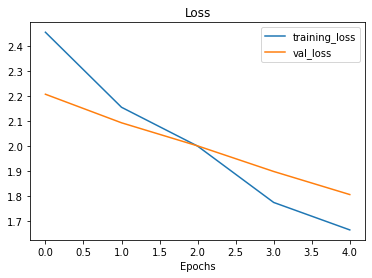

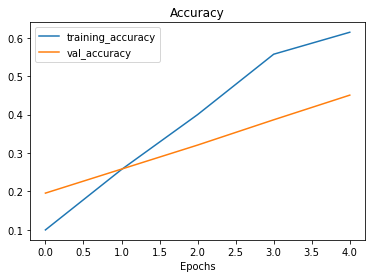

In [26]:
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction Transfer Learning on 10% of data with data augmenatation

In [27]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Adding data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=False)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax")(x)

# Make a model using the inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug")])

2023-01-26 08:10:23.891996: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:10:23.892040: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 08:10:24.186248: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:10:24.186424: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230126-081023
Epoch 1/5
 1/24 [>.............................] - ETA: 2:07 - loss: 2.3451 - accuracy: 0.0312

2023-01-26 08:10:30.228000: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:10:30.228237: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 16s - loss: 2.3464 - accuracy: 0.0781 

2023-01-26 08:10:31.060474: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 08:10:31.061829: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 08:10:31.224088: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 502 callback api events and 499 activity events. 
2023-01-26 08:10:31.239987: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/24 [==>...........................] - ETA: 15s - loss: 2.3432 - accuracy: 0.1146

2023-01-26 08:10:31.262239: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_data_aug/20230126-081023/train/plugins/profile/2023_01_26_08_10_31

2023-01-26 08:10:31.275862: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_data_aug/20230126-081023/train/plugins/profile/2023_01_26_08_10_31/a625c8d8be8a.trace.json.gz
2023-01-26 08:10:31.314680: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_data_aug/20230126-081023/train/plugins/profile/2023_01_26_08_10_31

2023-01-26 08:10:31.322223: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to transfer_learning/10_percent_data_aug/20230126-081023/train/plugins/profile/2023_01_26_08_10_31/a625c8d8be8a.memory_profile.json.gz
2023-01-26 08:10:31.323714: I tensorflow/core/profiler/rpc/cli

24/24 [==============================] - 12s 268ms/step - loss: 1.8797 - accuracy: 0.4333 - val_loss: 1.3516 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 5s 182ms/step - loss: 1.0981 - accuracy: 0.7773 - val_loss: 0.8735 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 5s 181ms/step - loss: 0.7943 - accuracy: 0.8240 - val_loss: 0.7236 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 4s 158ms/step - loss: 0.6440 - accuracy: 0.8613 - val_loss: 0.6454 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5484 - accuracy: 0.8800 - val_loss: 0.5746 - val_accuracy: 0.8487


In [28]:
# Evaluate on the fill test dataset
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 85ms/step - loss: 0.6081 - accuracy: 0.8344


[0.6080561280250549, 0.8343999981880188]

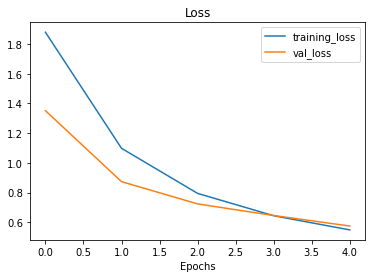

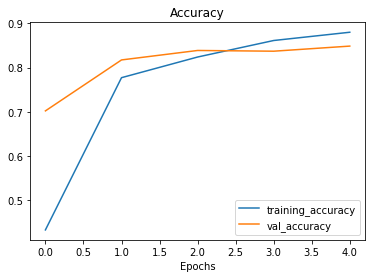

In [29]:
plot_loss_curves(history_model_2)

In [30]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Create Model Checkpointing callback

In [31]:
# Set Checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint Callback

In [32]:
# Fit the model using checkpoint callback
initial_epochs=5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
#                               steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(len(test_data) * 0.25),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                        checkpoint_callback])

2023-01-26 08:11:04.078664: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:11:04.078710: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 08:11:04.344093: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:11:04.344281: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230126-081104
Epoch 1/5
 1/24 [>.............................] - ETA: 12s - loss: 0.4203 - accuracy: 0.9375

2023-01-26 08:11:05.274156: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:11:05.274220: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 11s - loss: 0.4423 - accuracy: 0.9531

2023-01-26 08:11:05.791262: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 08:11:05.792138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 08:11:05.947597: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 502 callback api events and 499 activity events. 
2023-01-26 08:11:05.961925: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:11:05.981277: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_data_aug/20230126-081104/train/plugins/profile/2023_01_26_08_11_05



 3/24 [==>...........................] - ETA: 10s - loss: 0.4132 - accuracy: 0.9375

2023-01-26 08:11:05.995846: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_data_aug/20230126-081104/train/plugins/profile/2023_01_26_08_11_05/a625c8d8be8a.trace.json.gz
2023-01-26 08:11:06.030038: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_data_aug/20230126-081104/train/plugins/profile/2023_01_26_08_11_05

2023-01-26 08:11:06.037532: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to transfer_learning/10_percent_data_aug/20230126-081104/train/plugins/profile/2023_01_26_08_11_05/a625c8d8be8a.memory_profile.json.gz
2023-01-26 08:11:06.038965: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: transfer_learning/10_percent_data_aug/20230126-081104/train/plugins/profile/2023_01_26_08_11_05
Dumped tool data for xplane.pb to transfer_learning/10_perce

24/24 [==============================] - 5s 184ms/step - loss: 0.4785 - accuracy: 0.9027 - val_loss: 0.5419 - val_accuracy: 0.8586

Epoch 00001: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


2023-01-26 08:11:22.038758: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
24/24 [==============================] - 4s 152ms/step - loss: 0.4245 - accuracy: 0.9147 - val_loss: 0.5196 - val_accuracy: 0.8618

Epoch 00002: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.3817 - accuracy: 0.9333 - val_loss: 0.5221 - val_accuracy: 0.8536

Epoch 00003: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
24/24 [==============================] - 5s 183ms/step - loss: 0.3447 - accuracy: 0.9427 - val_loss: 0.4941 - val_accuracy: 0.8635

Epoch 00004: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.3138 - accuracy: 0.9533 - val_loss: 0.4847 - val_accuracy: 0.8602

Epoch 00005: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6075 - accuracy: 0.8456


[0.6075265407562256, 0.8456000089645386]

In [34]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 70ms/step - loss: 0.4994 - accuracy: 0.8512


[0.4993646442890167, 0.8511999845504761]

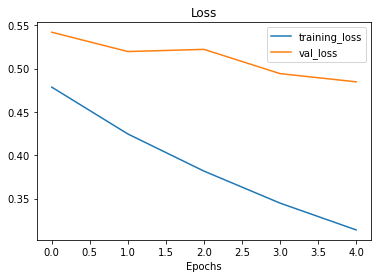

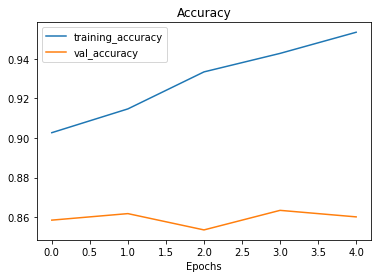

In [35]:
# Plot model loss curves
plot_loss_curves(history_model_2)

### Loading in checkpointed weights

In [36]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

2023-01-26 08:14:50.496766: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ten_percent_model_checkpoint_weights/checkpoint.ckpt: Failed precondition: ten_percent_model_checkpoint_weights/checkpoint.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [37]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4994 - accuracy: 0.8512


In [38]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

True

In [39]:
# Check to see if loaded model results are very close to our previous non_loaded model_2
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [40]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

✏️**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [41]:
# Layers in loaded model
model_2.layers

In [42]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6cf904d790> True
<keras.engine.sequential.Sequential object at 0x7f708e044290> True
<keras.engine.functional.Functional object at 0x7f6cf90d1b10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6cf904d710> True
<keras.layers.core.Dense object at 0x7f6cf8d60050> True


In [43]:
# What layers are in our base_model and are they trainables?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
for layer in model_2.layers[2].layers[-10:]:
    layer.trainable = True

In [46]:
# To begin fine-tuning let's start by setting the last 10 layers of our base-model
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False

# for layer in base_model.layers[-10:]:
#     print(layer.name, layer.trainable)
    
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

✏️ **Note:** Biasanya, saat fine-tuning sebuah model, kita menggunakan nilai learning rate yang lebih kecil dari defaultnya, berapa? biasanya minimal 1/10 dari default. Tapi berbagai sumber bisa bilang beda"

In [47]:
# How many trainable variables are in our base model after we unfrozen the last 10 layers
print(len(model_2.layers[2].trainable_variables))

10


In [48]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=int(len(test_data)*0.25),
                                              initial_epoch=history_model_2.epoch[-1],
                                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10")])

2023-01-26 08:15:03.758825: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:15:03.759531: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-26 08:15:04.485915: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:15:04.486135: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230126-081503
Epoch 5/10
 1/24 [>.............................] - ETA: 2:17 - loss: 0.1988 - accuracy: 1.0000

2023-01-26 08:15:11.095606: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-26 08:15:11.095667: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 29s - loss: 0.3042 - accuracy: 0.9844 

2023-01-26 08:15:12.553734: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-26 08:15:12.563959: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-26 08:15:12.729985: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 585 callback api events and 582 activity events. 
2023-01-26 08:15:12.758794: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-26 08:15:12.789770: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: transfer_learning/10_percent_fine_tune_last_10/20230126-081503/train/plugins/profile/2023_01_26_08_15_12

2023-01-26 08:15:12.805908: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_fine_tune_last_10/20230126-081503/train/plugins/profile/2023_01_26_08_15_12/a625c8d8be8a.trace.json.gz
2023-0

24/24 [==============================] - 14s 342ms/step - loss: 0.2630 - accuracy: 0.9480 - val_loss: 0.4141 - val_accuracy: 0.8635
Epoch 6/10
24/24 [==============================] - 5s 187ms/step - loss: 0.1734 - accuracy: 0.9613 - val_loss: 0.4121 - val_accuracy: 0.8651
Epoch 7/10
24/24 [==============================] - 5s 196ms/step - loss: 0.1297 - accuracy: 0.9693 - val_loss: 0.4088 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 5s 187ms/step - loss: 0.0980 - accuracy: 0.9813 - val_loss: 0.4014 - val_accuracy: 0.8750
Epoch 9/10
24/24 [==============================] - 5s 188ms/step - loss: 0.0720 - accuracy: 0.9947 - val_loss: 0.3855 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 5s 187ms/step - loss: 0.0550 - accuracy: 0.9973 - val_loss: 0.4365 - val_accuracy: 0.8569


In [49]:
# Evaluate the fine-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4509 - accuracy: 0.8464


In [50]:
results_fine_tune_10_percent

[0.45090794563293457, 0.8464000225067139]

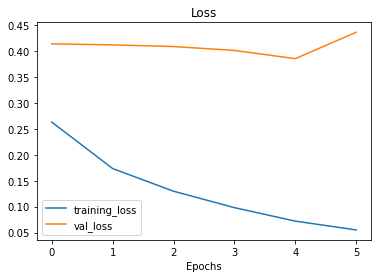

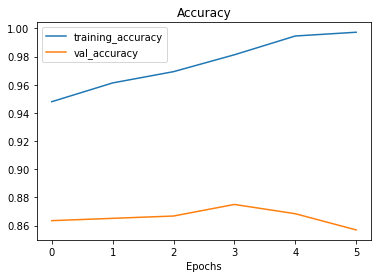

In [51]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [52]:
# Let's create a function 
def compare_history(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow History objects
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    
    # Make plots for accuracy
#     plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

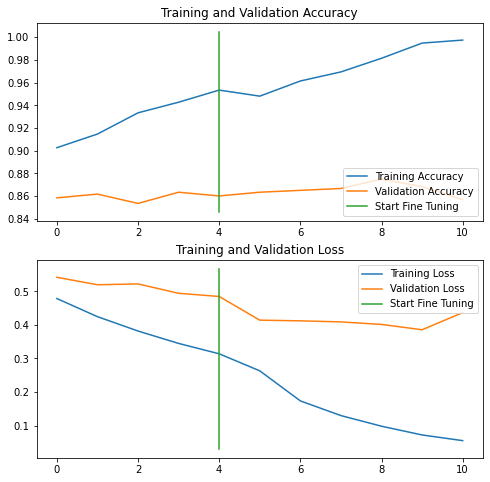

In [53]:
compare_history(history_model_2,
               history_fine_10_percent_data_aug,
               initial_epochs=5)